In [1]:
import pandas as pd
import sys
sys.path.append('../src')
from volpiano import clean_volpiano
import seaborn as sns
import matplotlib.pyplot as plt

# Cantus statistics

In [2]:
chants = pd.read_csv('../datasets/cantuscorpus/csv/chant.csv', index_col=0)
# sources = pd.read_csv('../datasets/cantuscorpus/csv/source.csv', index_col=0)

/Users/Bas/repos/papers/DLfM2020/env/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3072: DtypeWarning: Columns (16) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
for column in chants.columns:
    has_value = (chants[column].isnull() == False).sum()
    print(f'{column: <22} nonempty for {has_value: <6} chants ({has_value/len(chants):.2%})')

incipit                nonempty for 497055 chants (100.00%)
cantus_id              nonempty for 486827 chants (97.94%)
mode                   nonempty for 458227 chants (92.19%)
finalis                nonempty for 8919   chants (1.79%)
differentia            nonempty for 177299 chants (35.67%)
siglum                 nonempty for 497071 chants (100.00%)
position               nonempty for 392612 chants (78.99%)
folio                  nonempty for 497036 chants (99.99%)
sequence               nonempty for 497034 chants (99.99%)
marginalia             nonempty for 14031  chants (2.82%)
cao_concordances       nonempty for 264788 chants (53.27%)
feast_id               nonempty for 488697 chants (98.32%)
genre_id               nonempty for 493102 chants (99.20%)
office_id              nonempty for 494954 chants (99.57%)
source_id              nonempty for 456248 chants (91.79%)
melody_id              nonempty for 91     chants (0.02%)
drupal_path            nonempty for 497071 chants (100.00

# Gregobase

In [4]:
gb_chants = pd.read_csv('../datasets/gregobasecorpus/csv/chants.csv', index_col=0)

In [5]:
for column in gb_chants.columns:
    has_value = (gb_chants[column].isnull() == False).sum()
    print(f'{column: <22} nonempty for {has_value: <6} chants ({has_value/len(gb_chants):.2%})')

cantus_id              nonempty for 585    chants (6.40%)
version                nonempty for 8709   chants (95.29%)
incipit                nonempty for 9101   chants (99.58%)
initial                nonempty for 9139   chants (100.00%)
office_part            nonempty for 9020   chants (98.70%)
mode                   nonempty for 8441   chants (92.36%)
mode_var               nonempty for 1433   chants (15.68%)
transcriber            nonempty for 8525   chants (93.28%)
commentary             nonempty for 550    chants (6.02%)
gabc                   nonempty for 9135   chants (99.96%)
gabc_verses            nonempty for 147    chants (1.61%)
tex_verses             nonempty for 108    chants (1.18%)
remarks                nonempty for 507    chants (5.55%)


# How many chants are incipits?

What portion of the chants is complete, and what portion consists of only incipits? Working this out is not entirely straightforward, so we take the following approach. First, we check whether `incipit` is equal to `full_text`. If this is the case, then we certainly have an incipit. We can use this to estimate the length distribution of incipits, which we use to heuristically estimate the number of complete chants by checking whether they have at least a certain number of notes. This is indeed very naive.

In [6]:
subset = chants[chants.volpiano.isnull() == False]
lengths = subset.volpiano.map(clean_volpiano).map(len)

# Ignore outliers with more than 350 notes
subset = subset[(0 < lengths) & (lengths < 350)]
print('Ignored chants witout notes:', sum(lengths == 0))
print('Ignored outliers:', sum(lengths >= 350))
print('Remaining:', len(subset))

Ignored chants witout notes: 1825
Ignored outliers: 184
Remaining: 61619


In [7]:
lengths = subset.volpiano.map(clean_volpiano).map(len)
subset.loc[:, 'length'] = lengths

has_full_text = subset.full_text.isnull() == False
has_full_text_manuscript = subset.full_text_manuscript.isnull() == False
has_both = has_full_text & has_full_text_manuscript
is_incipit = has_both & (subset.full_text == subset.incipit)
subset.loc[:, 'is_incipit'] = is_incipit
print('Num certain incipits', is_incipit.sum())

Num certain incipits 8075


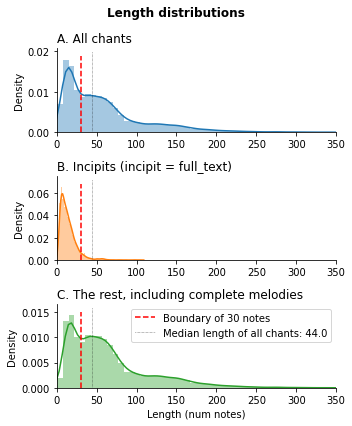

In [8]:
plt.figure(figsize=(5, 6))
bound = 30
median = lengths.median()

props = dict(ha='left', x=0)
plt.suptitle('Length distributions', fontweight='bold')

ax1 = plt.subplot(311)
plt.title('A. All chants', **props)
sns.distplot(lengths)
plt.xlim(0, 350)
plt.xlabel('')
plt.ylabel('Density')
plt.plot([bound, bound], plt.ylim(), 'r--')
plt.plot([median, median], plt.ylim(), 'k:', lw=.5)

plt.subplot(312, sharex=ax1)
plt.title('B. Incipits (incipit = full_text)', **props)
sns.distplot(lengths[is_incipit == True], color='C1')
plt.ylabel('Density')
plt.xlabel('')
plt.plot([bound, bound], plt.ylim(), 'r--')
plt.plot([median, median], plt.ylim(), 'k:', lw=.5)

plt.subplot(313, sharex=ax1)
plt.title('C. The rest, including complete melodies', **props)
sns.distplot(lengths[is_incipit == False], color='C2')
plt.xlabel('Length (num notes)')
plt.ylabel('Density')
plt.plot([bound, bound], plt.ylim(), 'r--', label=f'Boundary of {bound} notes')
plt.plot([median, median], plt.ylim(), 'k:', lw=.5, 
         label=f'Median length of all chants: {median}')

plt.legend() 
sns.despine()
plt.tight_layout()

In [9]:
perc_est_incipit = sum(lengths < bound) / len(subset)
print(f'Estimated percentage of incipits: {perc_est_incipit:.0%}')
print(f'Estimated percentage of complete melodies: {1-perc_est_incipit:.0%}')

Estimated percentage of incipits: 37%
Estimated percentage of complete melodies: 63%
